<a href="https://colab.research.google.com/github/Michael-Santoro/TrafficSignClassification/blob/main/comp4449_midterm_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recognizing Traffic Signs
**Michael Santoro - michael.santoro@du.edu**</br>
**COMP 4449 - Mid-Term Project**</br>
## Introduction
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise.
## Data Pre-Preparation
Code taken from the main.ipynb file from: https://github.com/emmanueliarussi/DataScienceCapstone/tree/master/3_MidtermProjects/ProjectRTS

### Data Download

In [1]:
# Download and unzip
dataroot = "dataroot/"
!mkdir dataroot 
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

# Unzip
import zipfile
with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)
with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
    zip_ref.extractall(dataroot)

!wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv 

mkdir: cannot create directory ‘dataroot’: File exists
--2023-01-18 03:29:25--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32074743 (31M) [application/zip]
Saving to: ‘dataroot/data_1.zip.8’

data_1.zip.8        100%[===================>]  30.59M   152MB/s    in 0.2s    

2023-01-18 03:29:26 (152 MB/s) - ‘dataroot/data_1.zip.8’ saved [32074743/32074743]

--2023-01-18 03:29:26--  https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to r

## Imports

In [2]:
import copy
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import time

from collections import Counter

from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms

# Data Preperation
- Provide an overall description of the dataset.
- Describe how the features and records are distributed.
## File Descriptions
The dataset consists of (3) zipped files that have been converted to train, valid, and test set files. There is a also a csv that is to be used as the label map.
## signnames.csv

In [3]:
# Load sign names
dataroot = "dataroot/"
df = pd.read_csv(f'{dataroot}signnames.csv')
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

We can see from the above output that we can expect 42 different types of signs included in the dataset. Meaning that this will be a multi-class classification problem.
## Data Exploration

In [4]:
# Load images
train = pickle.load( open( dataroot+"train.p", "rb" ) )
valid = pickle.load( open( dataroot+"valid.p", "rb" ) )
test = pickle.load( open( dataroot+"test.p", "rb" ) )

In [5]:
print(f'train.keys(): {train.keys()}')
print(f'valid.keys(): {valid.keys()}')
print(f'test.keys(): {test.keys()}')

train.keys(): dict_keys(['coords', 'labels', 'features', 'sizes'])
valid.keys(): dict_keys(['coords', 'labels', 'features', 'sizes'])
test.keys(): dict_keys(['sizes', 'coords', 'features', 'labels'])


We can see the data is a dict of values with different keys. We can go through each of the keys below.
### coords

In [6]:
type(train['coords'])

numpy.ndarray

In [7]:
train['coords'].shape

(34799, 4)

In [8]:
train['coords'][:10]

array([[ 6,  5, 21, 20],
       [ 6,  6, 22, 22],
       [ 5,  6, 22, 23],
       [ 5,  6, 22, 23],
       [ 5,  6, 23, 23],
       [ 6,  5, 25, 23],
       [ 6,  5, 25, 25],
       [ 5,  5, 25, 25],
       [ 6,  5, 26, 25],
       [ 6,  5, 27, 26]], dtype=uint8)

Assuming coors mean corrdinates this would be almost 35000 different coordinates. It seams like the 'coords' field may be an artifact of some previous data parsing as it appears to be the image within the image. So, we will be ignoring this field.
### labels
The 'labels' are expected to be integer values from 0-42 representing the actual sign in the image.

In [9]:
type(train['labels'])

numpy.ndarray

In [10]:
train['labels'].shape

(34799,)

In [11]:
print(f'Max of Labels: {train["labels"].max()}')
print(f'Min of Labels: {train["labels"].min()}')

Max of Labels: 42
Min of Labels: 0


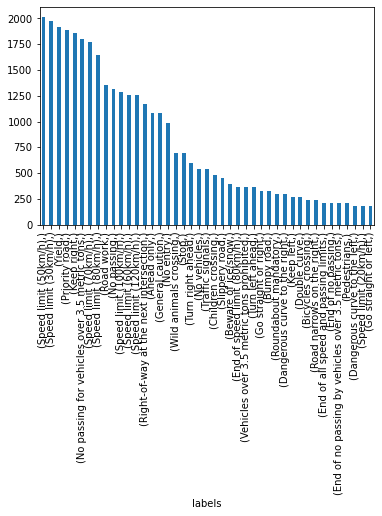

In [12]:
df =pd.DataFrame(train["labels"], columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

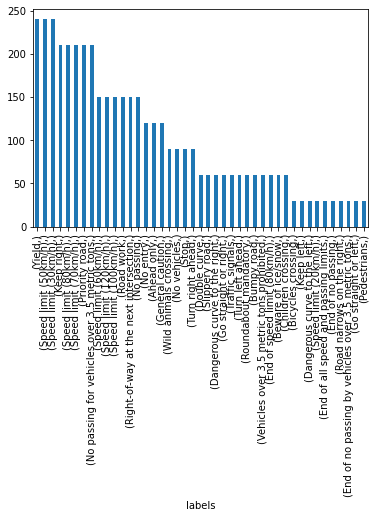

In [13]:
df =pd.DataFrame(valid["labels"], columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

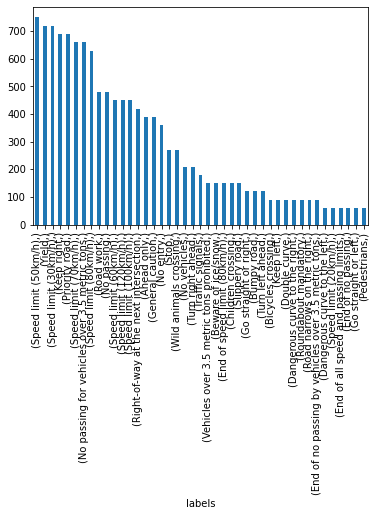

In [14]:
df =pd.DataFrame(test["labels"], columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

In the previous (3) plots there are a couple of important take aways:
 
1.   This is not a balanced data-set, that is to ay that in each of the datasets there are far less examples of certain signs. At this point we will take no action on this, but it is important to note incase we run into interesting results later we may need to re-visit this.
2.   For each of the sets of data the labels are not exactly balanced. That is to say in-between the Train, Validate, and Test set there are not 

### features

In [15]:
type(train['features'])

numpy.ndarray

In [16]:
print(f'train["features"].shape: {train["features"].shape}')
print(f'valid["features"].shape: {valid["features"].shape}')
print(f'test["features"].shape: {test["features"].shape}')

train["features"].shape: (34799, 32, 32, 3)
valid["features"].shape: (4410, 32, 32, 3)
test["features"].shape: (12630, 32, 32, 3)


### sizes

In [17]:
type(train['sizes'])

numpy.ndarray

In [18]:
train['sizes'].shape

(34799, 2)

In [19]:
train['sizes'][:10]

array([[26, 25],
       [27, 27],
       [27, 28],
       [27, 28],
       [29, 29],
       [30, 28],
       [31, 30],
       [30, 30],
       [32, 30],
       [32, 31]], dtype=uint8)

The image shows a Turn left ahead sign


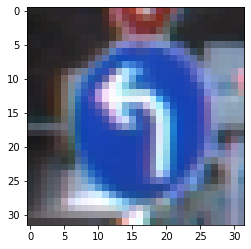

In [20]:
# Preview image
inx = 20123
plt.imshow(train['features'][inx])
print("The image shows a {} sign".format(signnames[train['labels'][inx]]))

## Wrap-Up
The key parts of the data that will be used will be the 'features' and the 'labels'.

## Balance Dataset
To train the signage equally we will be balancing the dataset.

In [21]:
def sampleIndicies(labels,label_count=43):
  indices = []
  count = Counter(labels)
  n = min(count.values())
  df=pd.DataFrame(labels, columns=['labels'])
  for i in range(label_count):
    indices+=random.sample(list(df[df.labels==i].index),n)
  return indices

In [22]:
train_index = sampleIndicies(list(train['labels']))
test_index = sampleIndicies(list(test['labels']))
valid_index = sampleIndicies(list(valid['labels']))

In [23]:
len(test_index)

2580

In [24]:
train_labels = np.take(train['labels'],train_index,axis=0)
train_images = np.take(train['features'],train_index,axis=0)
test_labels = np.take(test['labels'],test_index,axis=0)
test_images = np.take(test['features'],test_index,axis=0)
valid_labels = np.take(valid['labels'],valid_index,axis=0)
valid_images = np.take(valid['features'],valid_index,axis=0)


In [25]:
train_images.shape

(7740, 32, 32, 3)

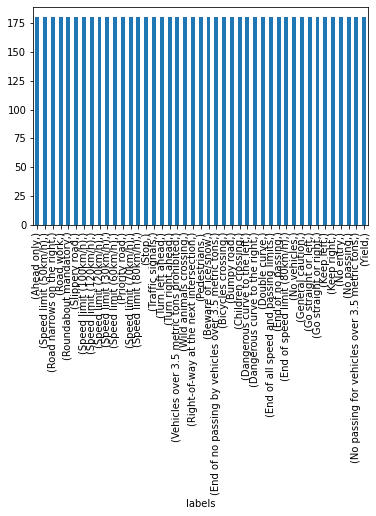

In [26]:
df =pd.DataFrame(train_labels, columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

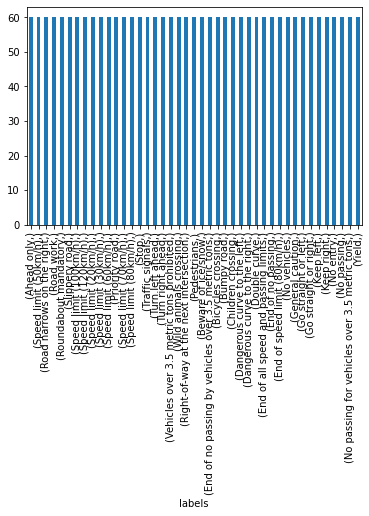

In [27]:
df =pd.DataFrame(test_labels, columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

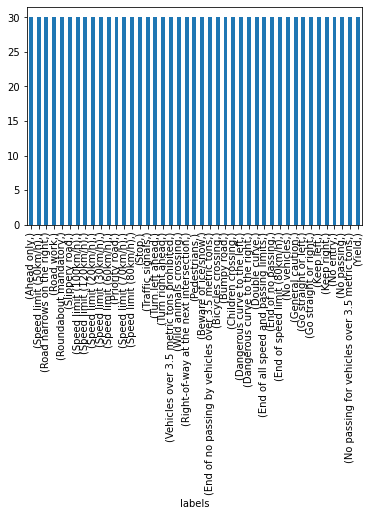

In [28]:
df =pd.DataFrame(valid_labels, columns=['labels'])
df2=df.replace({"labels": signnames})
df2.value_counts().plot(kind='bar')

# Data Analysis
Two Machine Learning classification techiques will be used to classify the images included in this dataset. Previously successful Convolutional Network Architectures will be used to classify the images.

## Pre-Trained Models
Pre-Trained models that have been trained on large datasets can be used to assist in our effort to identify signs. Pytorch vision will allow us to download pre-trained models so that we can baseline. We will be careful to only use the train set of data in this step. We will use transfer learning and follow along with this tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html


#### Helper Functions

In [29]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [30]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.cuda.empty_cache()

    return model,best_acc

In [31]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {signnames[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### AlexNet
- Paper: https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf
- Torch Source: https://pytorch.org/hub/pytorch_vision_alexnet/
- Description: The Alexnet architecture was a critical breakthrough in the field of computer vision for deep learning, using a CNN to classify images.
- Issue: min_size = 63x63 which is larger than the data provided so we would need to 

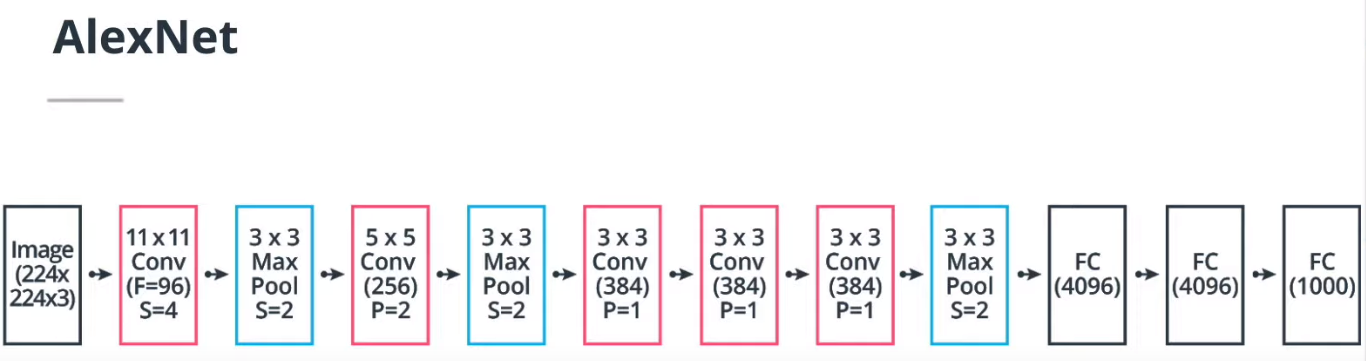

## Image Transform
Since out data as it is provided is 32 pixels by 32 pixels. We can use the torch transform package to convert the image to the appropiate torch format and re-size the image.

In [32]:
alexnet_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((63,63)),
    transforms.ToTensor()])



In [33]:
anet_train_images = [i for i in train_images]
anet_valid_images = [i for i in test_images]
anet_test_images = [i for i in valid_images]
train_tensors = list(map(alexnet_transform,anet_train_images))
valid_tensors = list(map(alexnet_transform,anet_valid_images))
anet_test_tensors = list(map(alexnet_transform,anet_test_images))

In [34]:
train_dataset = TensorDataset(torch.stack(train_tensors),torch.tensor(train_labels,dtype=torch.long)) # create your datset
valid_dataset = TensorDataset(torch.stack(valid_tensors) ,torch.tensor(test_labels,dtype=torch.long)) # create your datset

image_datasets = {'train':train_dataset,'val':valid_dataset}

In [35]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # create your dataloader
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True) # create your dataloader

dataloaders = {'train':train_loader,'val':valid_loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
#class_names = image_datasets['train'].classes

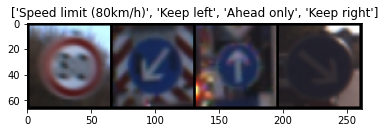

In [36]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Display n images of batch
n = 4

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:n])

imshow(out[:n], title=[signnames[x.item()] for x in classes[:n]])

It is important to note from the output above that we can see from the axis that the images have been successfully re-sized from the provided 32x32 to transformed 63x63.

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
alexnet = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', weights='AlexNet_Weights.DEFAULT')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Re-Format Classifier
Since we have different conditions in our problem then how Alexnet was trained on we need to re-define some of the nueral network. Specifically the classifier, which is at the end of the network. Which will be the fully connected layer reducing the network to the qty of sign labels and then adding a softmax to select the actual prediction. See the '(fc)' that has the len(labels) = 43 in the print out below.

In [39]:
new_classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
new_classifier.add_module('fc',nn.Linear(4096,len(signnames)))
new_classifier.add_module('softmax',nn.LogSoftmax(dim=1))
alexnet.classifier = new_classifier
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

### Train

In [40]:
alexnet = alexnet.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

alexnet,alexnet_best_acc = train_model(alexnet, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 2.3590 Acc: 0.3527
val Loss: 1.9533 Acc: 0.4229

Epoch 1/29
----------
train Loss: 1.0630 Acc: 0.6638
val Loss: 1.7001 Acc: 0.5333

Epoch 2/29
----------
train Loss: 0.7046 Acc: 0.7789
val Loss: 1.5335 Acc: 0.5640

Epoch 3/29
----------
train Loss: 0.5091 Acc: 0.8371
val Loss: 1.5730 Acc: 0.5771

Epoch 4/29
----------
train Loss: 0.3924 Acc: 0.8740
val Loss: 1.5957 Acc: 0.5957

Epoch 5/29
----------
train Loss: 0.3294 Acc: 0.8925
val Loss: 1.5215 Acc: 0.6194

Epoch 6/29
----------
train Loss: 0.2536 Acc: 0.9167
val Loss: 1.6713 Acc: 0.6081

Epoch 7/29
----------
train Loss: 0.1732 Acc: 0.9505
val Loss: 1.4882 Acc: 0.6457

Epoch 8/29
----------
train Loss: 0.1474 Acc: 0.9601
val Loss: 1.4933 Acc: 0.6512

Epoch 9/29
----------
train Loss: 0.1430 Acc: 0.9589
val Loss: 1.5209 Acc: 0.6453

Epoch 10/29
----------
train Loss: 0.1359 Acc: 0.9610
val Loss: 1.5071 Acc: 0.6585

Epoch 11/29
----------
train Loss: 0.1312 Acc: 0.9627
val Loss: 1.5183 Acc: 0.6558

Ep

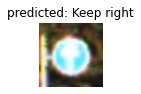

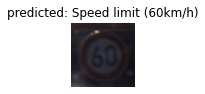

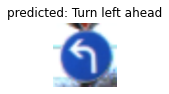

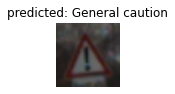

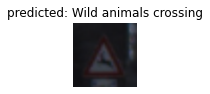

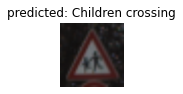

In [41]:
## Visualize Results from Validation Set
visualize_model(alexnet)

### VGG
- Paper: https://arxiv.org/pdf/1409.1556.pdf
- Torch Source: https://pytorch.org/vision/master/models/generated/torchvision.models.vgg16.html#torchvision.models.vgg16
- Description: Using smaller filter sizes, in this case 3x3 filters and using convolutional blocks of 2 or 3 convolutional layers followed by one pooling layer. By stacking multiple convolutional layers with small filters, we create a block that has less parameters than a single layer with larger filter sizes, while having the same effective receptive field and more non-linearities.

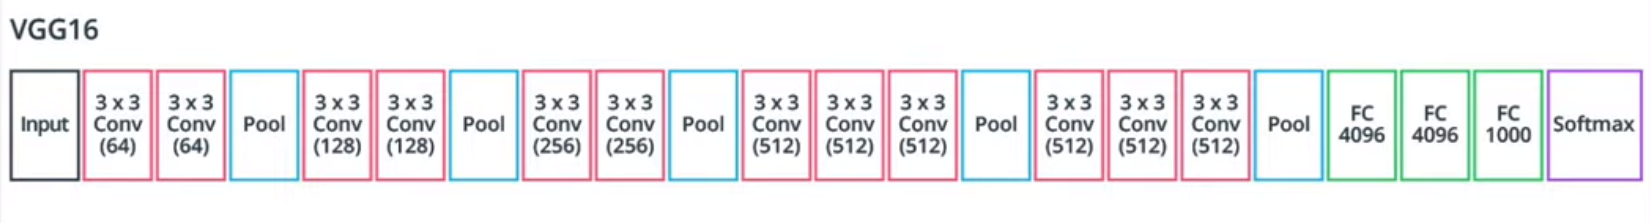

In [42]:
vgg_transform = transforms.Compose([
    transforms.ToTensor()])


In [43]:
vgg_train_images = [i for i in train_images]
vgg_valid_images = [i for i in test_images]
vgg_test_images = [i for i in valid_images]
train_tensors = list(map(vgg_transform,vgg_train_images))
valid_tensors = list(map(vgg_transform,vgg_valid_images))
vgg_test_tensors = list(map(vgg_transform,vgg_test_images))

In [44]:
train_dataset = TensorDataset(torch.stack(train_tensors),torch.tensor(train_labels,dtype=torch.long)) # create your datset
valid_dataset = TensorDataset(torch.stack(valid_tensors) ,torch.tensor(test_labels,dtype=torch.long)) # create your datset

image_datasets = {'train':train_dataset,'val':valid_dataset}

In [45]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True) # create your dataloader
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=True) # create your dataloader

dataloaders = {'train':train_loader,'val':valid_loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#class_names = image_datasets['train'].classes

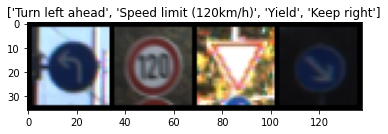

In [46]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Display n images of batch
n = 4

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:n])

imshow(out[:n], title=[signnames[x.item()] for x in classes[:n]])

In [47]:
vgg16 = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', weights='VGG16_Weights.IMAGENET1K_V1')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [48]:
vgg16_classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
vgg16_classifier.add_module('fc',nn.Linear(4096,len(signnames)))
vgg16_classifier.add_module('softmax',nn.LogSoftmax(dim=1))
vgg16.classifier = vgg16_classifier
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Model Training

In [49]:
vgg16 = vgg16.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

vgg16,vgg16_best_acc = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 2.9233 Acc: 0.2017
val Loss: 2.0138 Acc: 0.3705

Epoch 1/29
----------
train Loss: 1.2827 Acc: 0.5873
val Loss: 1.2869 Acc: 0.6062

Epoch 2/29
----------
train Loss: 0.6206 Acc: 0.7925
val Loss: 0.9958 Acc: 0.6895

Epoch 3/29
----------
train Loss: 0.3658 Acc: 0.8758
val Loss: 0.9418 Acc: 0.7310

Epoch 4/29
----------
train Loss: 0.2567 Acc: 0.9111
val Loss: 0.7361 Acc: 0.7744

Epoch 5/29
----------
train Loss: 0.1491 Acc: 0.9490
val Loss: 0.6818 Acc: 0.8120

Epoch 6/29
----------
train Loss: 0.1274 Acc: 0.9587
val Loss: 0.6793 Acc: 0.8089

Epoch 7/29
----------
train Loss: 0.0654 Acc: 0.9818
val Loss: 0.5517 Acc: 0.8442

Epoch 8/29
----------
train Loss: 0.0508 Acc: 0.9848
val Loss: 0.5663 Acc: 0.8484

Epoch 9/29
----------
train Loss: 0.0455 Acc: 0.9859
val Loss: 0.5604 Acc: 0.8512

Epoch 10/29
----------
train Loss: 0.0419 Acc: 0.9870
val Loss: 0.5723 Acc: 0.8539

Epoch 11/29
----------
train Loss: 0.0403 Acc: 0.9875
val Loss: 0.5692 Acc: 0.8578

Ep

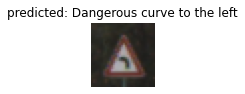

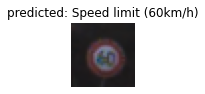

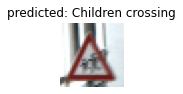

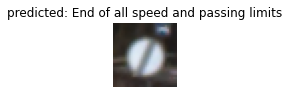

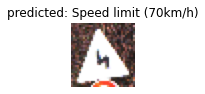

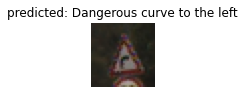

In [50]:
visualize_model(vgg16)

# Data Visualization
- Use visualization techniques to show the results.

In [67]:
print(f'Alexnet Best Accuracy During Training: {alexnet_best_acc*100:.2f} %')
print(f'VGG Best Accuracy During Training: {vgg16_best_acc*100:.2f} %')

Alexnet Best Accuracy During Training: 66.28 %
VGG Best Accuracy During Training: 86.28 %


## Alexnet

In [52]:

alexnet_test_ds = TensorDataset(torch.stack(anet_test_tensors),torch.tensor(valid_labels,dtype=torch.long))
alexnet_test_loader = DataLoader(alexnet_test_ds, batch_size=4, shuffle=False)

In [53]:
y_true = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(alexnet_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true += labels.tolist()
        outputs = alexnet(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred += preds.tolist()

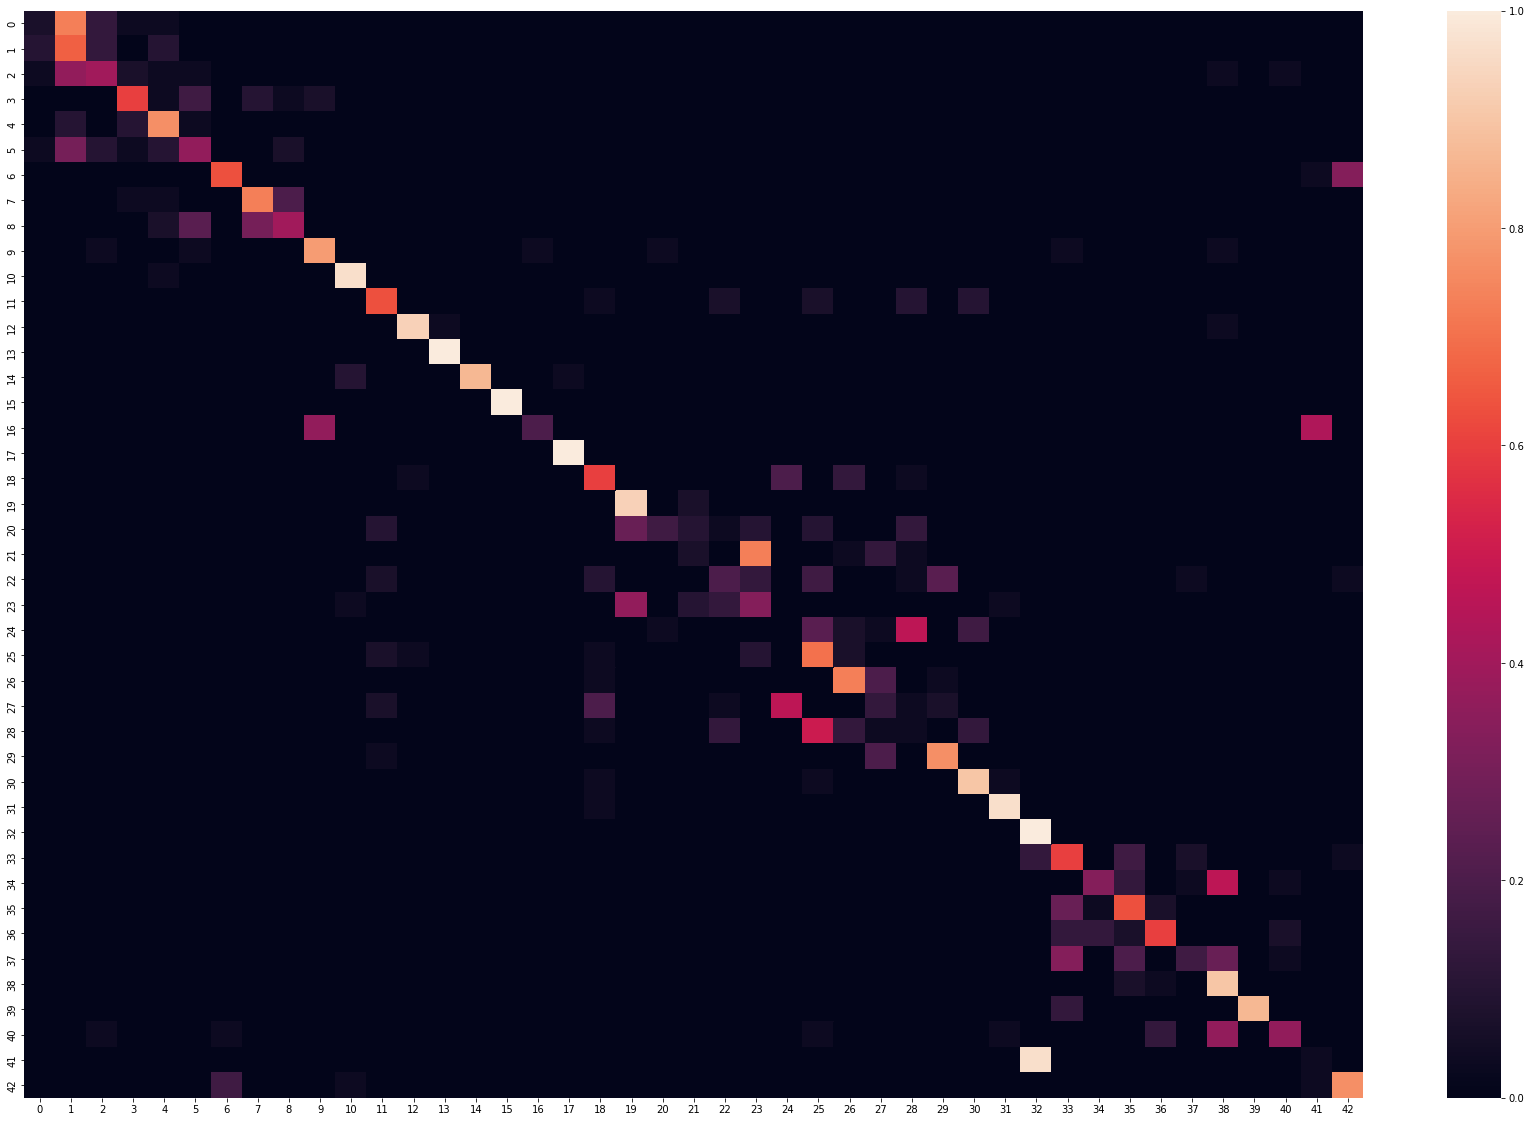

In [54]:
cf_matrix = confusion_matrix(y_true,y_pred, normalize='true')
plt.figure(figsize=(30,20))

sns.heatmap(cf_matrix)

In [55]:
f1_scores = f1_score(y_true, y_pred, average=None)
f1_scores_with_labels = {signnames[label]:score for label,score in enumerate(f1_scores)}
pd.DataFrame({'labels':list(f1_scores_with_labels.keys()),'f1_scores':list(f1_scores_with_labels.values())}).sort_values('f1_scores')

,labels,f1_scores
24,Road narrows on the right,0.000000
28,Children crossing,0.035714
41,End of no passing,0.043478
21,Double curve,0.100000
0,Speed limit (20km/h),0.108108
27,Pedestrians,0.153846
22,Bumpy road,0.250000
37,Go straight or left,0.256410
20,Dangerous curve to the right,0.270270
23,Slippery road,0.277778


In [56]:
matrix = confusion_matrix(y_true, y_pred)
accuracy_scores_with_labels = {signnames[label]:score for label,score in enumerate(matrix.diagonal()/matrix.sum(axis=1))}
pd.DataFrame({'labels':list(accuracy_scores_with_labels.keys()),'accuracy_scores':list(accuracy_scores_with_labels.values())}).sort_values('accuracy_scores').head(10)

,labels,accuracy_scores
24,Road narrows on the right,0.000000
28,Children crossing,0.033333
41,End of no passing,0.033333
0,Speed limit (20km/h),0.066667
21,Double curve,0.066667
27,Pedestrians,0.133333
37,Go straight or left,0.166667
20,Dangerous curve to the right,0.166667
22,Bumpy road,0.200000
16,Vehicles over 3.5 metric tons prohibited,0.200000


In [57]:
pd.DataFrame({'labels':list(accuracy_scores_with_labels.keys()),'accuracy_scores':list(accuracy_scores_with_labels.values())}).sort_values('accuracy_scores').tail(10)

,labels,accuracy_scores
30,Beware of ice/snow,0.900000
38,Keep right,0.900000
19,Dangerous curve to the left,0.933333
12,Priority road,0.933333
31,Wild animals crossing,0.966667
10,No passing for vehicles over 3.5 metric tons,0.966667
32,End of all speed and passing limits,1.000000
17,No entry,1.000000
15,No vehicles,1.000000
13,Yield,1.000000


In [58]:
alexnet_acc_score=accuracy_score(y_true,y_pred)

## VGG

In [59]:
vgg_test_ds = TensorDataset(torch.stack(vgg_test_tensors),torch.tensor(valid_labels,dtype=torch.long))
vgg_test_loader = DataLoader(vgg_test_ds, batch_size=4, shuffle=False)

In [60]:
y_true = []
y_pred = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(alexnet_test_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_true += labels.tolist()
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred += preds.tolist()


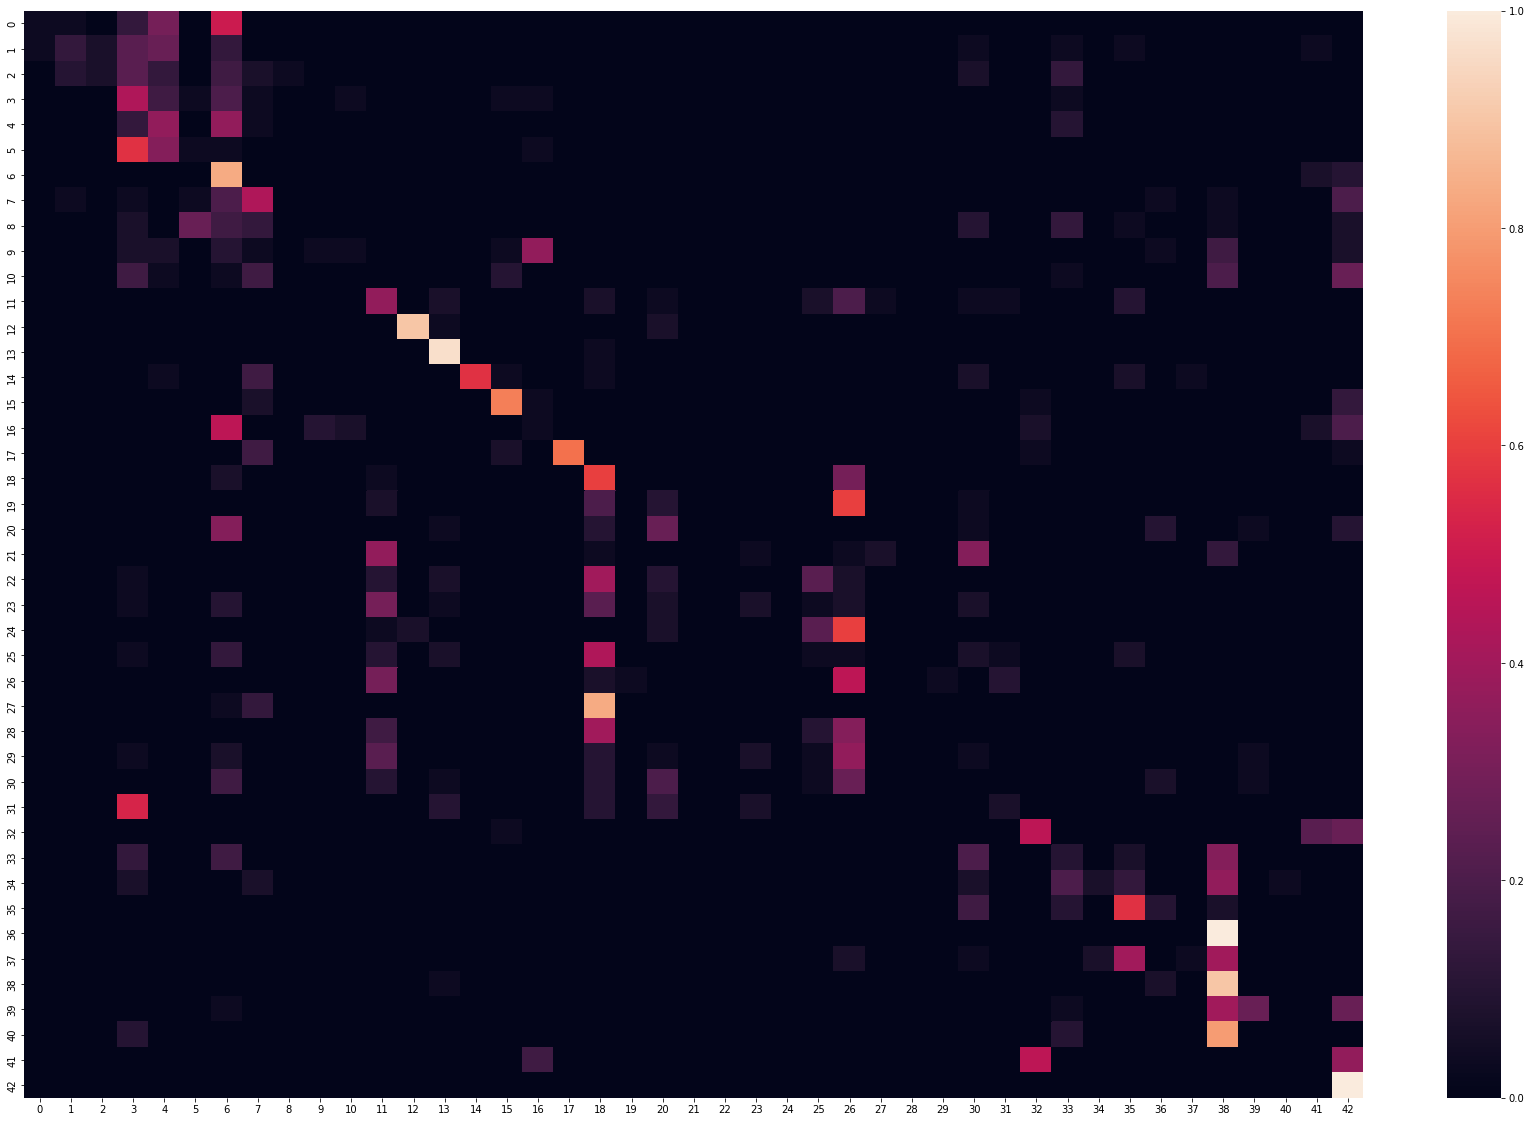

In [61]:
cf_matrix = confusion_matrix(y_true,y_pred,normalize='true')
plt.figure(figsize=(30,20))

sns.heatmap(cf_matrix)

In [62]:
f1_scores = f1_score(y_true, y_pred, average=None)
f1_scores_with_labels = {signnames[label]:score for label,score in enumerate(f1_scores)}
pd.DataFrame({'labels':list(f1_scores_with_labels.keys()),'f1_scores':list(f1_scores_with_labels.values())}).sort_values('f1_scores')

,labels,f1_scores
21,Double curve,0.000000
41,End of no passing,0.000000
22,Bumpy road,0.000000
24,Road narrows on the right,0.000000
27,Pedestrians,0.000000
10,No passing for vehicles over 3.5 metric tons,0.000000
28,Children crossing,0.000000
8,Speed limit (120km/h),0.000000
30,Beware of ice/snow,0.000000
36,Go straight or right,0.000000


In [63]:
matrix = confusion_matrix(y_true, y_pred)
accuracy_scores_with_labels = {signnames[label]:score for label,score in enumerate(matrix.diagonal()/matrix.sum(axis=1))}
pd.DataFrame({'labels':list(accuracy_scores_with_labels.keys()),'accuracy_scores':list(accuracy_scores_with_labels.values())}).sort_values('accuracy_scores').head(10)

,labels,accuracy_scores
21,Double curve,0.0
40,Roundabout mandatory,0.0
36,Go straight or right,0.0
30,Beware of ice/snow,0.0
29,Bicycles crossing,0.0
28,Children crossing,0.0
27,Pedestrians,0.0
8,Speed limit (120km/h),0.0
10,No passing for vehicles over 3.5 metric tons,0.0
24,Road narrows on the right,0.0


In [64]:
pd.DataFrame({'labels':list(accuracy_scores_with_labels.keys()),'accuracy_scores':list(accuracy_scores_with_labels.values())}).sort_values('accuracy_scores').tail(10)

,labels,accuracy_scores
14,Stop,0.566667
35,Ahead only,0.566667
18,General caution,0.600000
17,No entry,0.700000
15,No vehicles,0.733333
6,End of speed limit (80km/h),0.833333
38,Keep right,0.900000
12,Priority road,0.900000
13,Yield,0.966667
42,End of no passing by vehicles over 3.5 metric ...,1.000000


In [65]:
vgg_acc_score=accuracy_score(y_true,y_pred)

## Overall Model Scores

In [66]:
print(f'Alexnet Test Accuracy: {alexnet_acc_score*100:.2f} %')
print(f'VGG Test Accuracy: {vgg_acc_score*100:.2f} %')

Alexnet Test Accuracy: 57.75 %
VGG Test Accuracy: 26.82 %


## Questions
- Any other multi-class classification metrics or visualizations I should include?

Average Accuracy
Values per Class
Cost Model, confusion is not symmetric, mis-classification, this can map to map into accuracy
Need to average and normalize the heat map.